In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix
import seaborn as sns

In [2]:
df = pd.read_csv("aac_shelter_outcomes.csv")
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [3]:
print(df.shape)
print(df.columns)

(78256, 12)
Index(['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color',
       'date_of_birth', 'datetime', 'monthyear', 'name', 'outcome_subtype',
       'outcome_type', 'sex_upon_outcome'],
      dtype='object')


In [4]:
df.index

RangeIndex(start=0, stop=78256, step=1)

Используя данные приюта для животных, поставим себе задачу, к примеру, определить, почему забирают животных.

Сперва сделаем столбчатый график, чтобы визуализировать распределение причин, по которым животные покидают приют. 

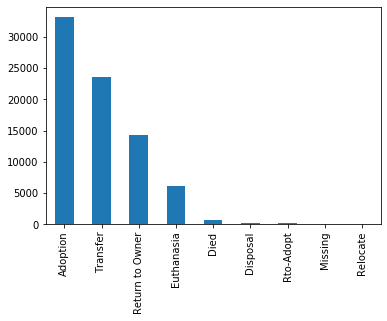

In [5]:
df = pd.read_csv('aac_shelter_outcomes.csv')
df['outcome_type'].value_counts().plot.bar()
plt.show()

На первом месте причин - взятие новыми хозяевами, на втором - трансфер, потом возвращение хозяину.

In [6]:
df.dtypes

age_upon_outcome    object
animal_id           object
animal_type         object
breed               object
color               object
date_of_birth       object
datetime            object
monthyear           object
name                object
outcome_subtype     object
outcome_type        object
sex_upon_outcome    object
dtype: object

Все стобцы в датафрейме не нумерические. Их надо будет пребразовать для использования в модели. 

Подсчитаем число уникальных значений в каждом параметре датафрейма:

In [12]:
columns = df.columns
for column in columns:
    print(column)
    print(df[column].nunique())

age_upon_outcome
46
animal_id
70855
animal_type
5
breed
2128
color
525
date_of_birth
5869
datetime
64361
monthyear
64361
name
14574
outcome_subtype
19
outcome_type
9
sex_upon_outcome
5


Проверим отстутсвующие данные:

In [13]:
df.apply(lambda x: sum(x.isnull()/len(df)))

age_upon_outcome    0.000102
animal_id           0.000000
animal_type         0.000000
breed               0.000000
color               0.000000
date_of_birth       0.000000
datetime            0.000000
monthyear           0.000000
name                0.305229
outcome_subtype     0.540444
outcome_type        0.000153
sex_upon_outcome    0.000026
dtype: float64

В двух параметрах: “name” (имя) и “outcome_subtype” (подтип выхода) мы видим большое количество отсутствующих данных. И небольшое количество для “sex_upon_outcome” (пол при выходе) и “age_upon_outcome” (возраст при выходе).

Параметр “outcome_subtype” (подтип выхода) является вторичным по отношению к параметру, который мы исследуем - "тип выхода" - и поэтому его можно удалить из списка параметров модели: 

In [14]:
df = df.drop('outcome_subtype', axis=1)

"Имя" может влиять на тип выхода - особенно на тип "Возвращение владельцу". Но т.к. отстутсвующее имя не выяснить, то введем новый параметр "has_name" (имеет имя) и будем присваивать 0, когда его нет, и 1, когда есть. Заполним 0 пустые значения в столбце "Name". Потом создаем новый стобец "has_name". Потом удаляем столбце "Name", тк он уже не пригодится.

In [15]:
df['name'] = df[['name']].fillna(value=0)
df['has_name'] = (df['name'] != 0).astype('int64')
df = df.drop('name', axis=1)

Для параметров "sex_upon_outcome” и "age_upon_outcome" отсутствующие позиции заполним наиболее часто встречающимися значениями, тк в целом у них пропусков немного.

In [16]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))
df.apply(lambda x: sum(x.isnull()/len(df)))

age_upon_outcome    0.0
animal_id           0.0
animal_type         0.0
breed               0.0
color               0.0
date_of_birth       0.0
datetime            0.0
monthyear           0.0
outcome_type        0.0
sex_upon_outcome    0.0
has_name            0.0
dtype: float64

Удалим параметр animal_id тк он не влияет на исследуемую нами модель.

In [17]:
df = df.drop('animal_id', axis=1)

Чтобы уменьшить количество уникальных значений параметра Цвет, уберем все значения встречающиеся менее 300 раз в параметр Другие (Others) и создадим новый параметр - Топовые цвета (top_colors):

In [18]:
color_counts = df['color'].value_counts()
color_others = set(color_counts[color_counts < 300].index)
df['top_colors'] = df['color'].replace(list(color_others), 'Others')
print(df['top_colors'].nunique())

46


Мы сократили количество уникальных значений с 525 до 46.

Введем новый параметр Тип породы, где будет подразделение на чистые виды (pure) и смешанные (где содержится в названии породы MIX):

In [19]:
import re
df['breed_type'] = df.breed.str.extract('({})'.format('|'.join(['Mix'])), 
                        flags=re.IGNORECASE, expand=False).str.lower().fillna('pure')

Введем новый параметр "Многоцветный" для разделения, когда у животного один цвет или несколько:

In [20]:
df['multi_colors'] = df['color'].apply(lambda x : 1 if '/' in x else 0)

Сконвертируем параметр Возраст при выходе (age_upon_outcome) в количество дней и запишем в age_numeric при помощи данной функции (а изначальный параметр удалим):

In [21]:
def age_converter(row):
    age_string = row['age_upon_outcome']
    [age,unit] = age_string.split(" ")
    unit = unit.lower()
    if("day" in unit):
        if age=='0': return 1
        return int(age)
    if("week" in unit):
        if(age)=='0': return 7
        return int(age)*7
    elif("month" in unit):
        if(age)=='0': return 30
        return int(age) * 4*7
    elif("year" in unit):
        if(age)=='0': return 365
        return int(age) * 4*12*7
df['age_numeric'] = df.apply(age_converter, axis=1)
df = df.drop('age_upon_outcome', axis=1)

Оставшиеся параметры модели конвертируем используя one hot encoding:

In [23]:
df = df.drop(['breed','color', 'datetime'], axis=1)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).drop(['outcome_type'], axis=1).columns
dummy_columns = pd.get_dummies(df[categorical_features])
final_df = pd.concat([dummy_columns, df],axis=1)
final_df = final_df.drop(['animal_type', 'breed_type', 'sex_upon_outcome', 'top_colors'], axis=1)

Теперь у нас в датасете нужные данные в нумерическом формате.

In [24]:
df.dtypes

animal_type         object
date_of_birth       object
monthyear           object
outcome_type        object
sex_upon_outcome    object
has_name             int64
top_colors          object
breed_type          object
multi_colors         int64
age_numeric          int64
dtype: object

Построим модель:

In [25]:
X = final_df.drop('outcome_type', axis=1)
y = final_df['outcome_type']
from sklearn.model_selection import train_test_split
X_df, X_test, y_df, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Используя RandomForestClassifier проверим точность модели:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                            random_state=0)
rf_model = clf.fit(X_df, y_df)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
y_prob = rf_model.predict_proba(X_test)
print(log_loss(y_test, y_prob))

Не получилось произвести вычисления, тк компьютер зависал несколько раз.

Посмотрим, какие параметры оказывают наибольшее влияние на модель:

In [26]:
features=X.columns
importances = rf_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,20))
plt.title('Важность параметров')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show

NameError: name 'rf_model' is not defined

The output show that features relating to the presence or absence of a name, age, sex and animal type are of particular importance.

There is likely to be a lot more work we can do here to improve the performance of this model. For example there are many more possibilities for transforming the categorical variables than I have listed here. As with a lot of data science work much of this is down to trial and error. I hope that in this article I have given a broad introduction into the possibilities of how to handle categorical variables in a machine learning project.